# ДЗ 2

В этом задании нужно будет обучить архитектуру для задачи Image Classification. Вам нужно будет реализовать архитектуру, обучить ее, а так же выполнить некоторые дополнительные задания.

В качестве датасета будет использовать вот этот - https://www.kaggle.com/datasets/slothkong/10-monkey-species

# Dataset

## Download from Kaggle

In [1]:
import zipfile
import shutil
import json
import os

In [2]:
with open('kaggle.json') as f:
    account = json.load(f)
    os.environ['KAGGLE_USERNAME'] = account["username"]
    os.environ['KAGGLE_KEY'] = account["key"]
import kaggle

In [3]:
def clear_directory(path_to_dir: str, force: bool):
    if force and os.path.exists(path_to_dir):
        shutil.rmtree(path_to_dir)
    if force or not os.path.exists(path_to_dir):
        os.makedirs(path_to_dir)
        return True
    if not os.listdir(path_to_dir):
        return True
    
    return False

In [4]:
def download_dataset_from_kaggle(kaggle_dataset_id: str, out_directory: str, overwrite: bool = False):
    if not clear_directory(out_directory, overwrite):
        print("Directory is already occupied")
        return
    
    kaggle.api.dataset_download_files(kaggle_dataset_id,
                                      path=out_directory,
                                      quiet=False)
    filename = f"{out_directory}/{kaggle_dataset_id.split('/')[-1]}.zip"
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(out_directory)
    os.remove(filename)

In [5]:
dataset_name = "slothkong/10-monkey-species"
data_path = "./data"
download_dataset_from_kaggle(dataset_name, data_path)

Directory is already occupied


## Prepare torch dataset

In [6]:
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.models as models
import pytorch_lightning as pl
import torch.nn as nn
from torchmetrics import Accuracy
import torch.optim as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
from PIL import Image
import random

In [7]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [8]:
train_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.CenterCrop(size=(224,224)),
              transforms.ToTensor()
        ])
val_transforms = transforms.Compose([
              transforms.Resize(size=(224,224)),
              transforms.ToTensor()
        ])

In [9]:
train_ds = ImageFolder('./data/training/training/',transform=train_transforms)
val_ds = ImageFolder('./data/validation/validation/',transform=val_transforms)

In [10]:
print(f'Class statistics in train dataset: {Counter(train_ds.targets)}')
print(f'Class statistics in train dataset: {Counter(val_ds.targets)}')

Class statistics in train dataset: Counter({3: 122, 7: 114, 5: 113, 1: 111, 2: 110, 6: 106, 8: 106, 0: 105, 4: 105, 9: 105})
Class statistics in train dataset: Counter({3: 30, 1: 28, 5: 28, 7: 28, 2: 27, 8: 27, 0: 26, 4: 26, 6: 26, 9: 26})


# Dataloader

In [23]:
CONFIG = {"lr": 1e-5,
          "batch_size": 64,
          "epochs": 100,
          "div_factor": 1e+5}

In [12]:
train_dl = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=4)

In [13]:
id2clas = {i:q for q,i in train_ds.class_to_idx.items()}

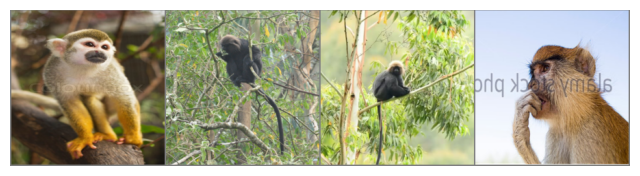

['n7', 'n9', 'n9', 'n1']


In [14]:
NUM_IMAGES = 4
samples = [train_ds[idx] for idx in np.random.randint(0,len(train_ds), 4)]
images = [i[0] for i in samples]
labels = [id2clas[i[1]] for i in samples]

img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()
print(labels)

## VGG.

Реализуйте VGG16 from scratch. Чтобы вспомнить архитектуру, обратитесь к лекции + оригинальной статье авторов+google.

Если хотите реализовать что-то поинтереснее (resnet, ViT???) - делайте, будет учтено.

Что будет оцениваться в задании:
* VGG16 from scratch **6 баллов**
* добавьте аугментаций, напишите краткое саммари почему выбрали именно такой набор аугментаций. **1 балл**
* дописать логику обучения модели **2 балла**
* дописать логику тестирования модели **1 балл**
* возьмите еще 2 модели из зоопарка моделей [torchvision](https://pytorch.org/vision/stable/models.html?), зафайнтюньте на наш датасет. Сравните их между собой и вашей реализацией. **4 балла**
* обязательно в конце напишите общий отчет о проделанной работе. Для лучшей модели проведите анализ метрик и ошибок, постройте confusion_matrix и classification report **2 балла**
* графики обучения обязательно должны присутсвовать

**NOTE**: рядом лежит ноутбук с baseline solution, вы можете отталкиваться от него, если хотите.

In [15]:
class VGG16(pl.LightningModule):
    def __init__(self, num_classes, lr=2e-4, num_epochs=10, steps_per_epoch=35, div_factor=1e+3):
        super().__init__()
        self.save_hyperparameters()
        self.num_epochs = num_epochs
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.lr = lr
        self.num_classes = num_classes
        self.model = nn.Sequential(
          nn.Conv2d(3,64,3),
          nn.ReLU(),
          nn.Conv2d(64,64,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d(112),
          nn.Conv2d(64,128,3),
          nn.ReLU(),
          nn.Conv2d(128,128,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d(56),
          nn.Conv2d(128,256,3),
          nn.ReLU(),
          nn.Conv2d(256,256,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d(28),
          nn.Conv2d(256,512,3),
          nn.ReLU(),
          nn.Conv2d(512,512,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d(14),
          nn.Conv2d(512,512,3),
          nn.ReLU(),
          nn.Conv2d(512,512,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d(7),
          nn.Flatten(),
          nn.Linear(25088, 4096),
          nn.ReLU(),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Linear(4096, num_classes),
          nn.ReLU()
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            epochs=self.num_epochs,
            steps_per_epoch=self.steps_per_epoch,
            max_lr=self.lr,
            pct_start=0.1,
            anneal_strategy='cos',
            final_div_factor=self.div_factor
        )
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('train_loss', loss.item(), on_step=False, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x,y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        
    def test_step(self, batch, batch_idx):
        x,y = batch
        preds = self(x)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('test_acc', acc, on_epoch=True, prog_bar=True)

# Train

In [16]:
model = VGG16(num_classes = 10, 
              num_epochs = CONFIG['epochs'], 
              steps_per_epoch = len(train_dl),
              lr = CONFIG['lr'],
              div_factor = CONFIG['div_factor'])
trainer_args = {
        "accelerator": "gpu",
        "max_epochs": CONFIG['epochs'],
        "default_root_dir": "vgg16/",
    }
trainer = pl.Trainer(**trainer_args,enable_progress_bar=True)
trainer.fit(model,train_dl,val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | Sequential         | 128 M 
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
128 M     Trainable params
0         Non-trainable params
128 M     Total params
515.967   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/dmitryindenbom/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Test and metrics

In [17]:
from tensorboard.backend.event_processing import event_accumulator
from typing import Iterable, Dict
import pandas as pd


def parse_tensorboard(path: str, scalars: Iterable):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k))["value"].to_numpy() for k in scalars}

In [18]:
from pathlib import Path


def get_most_recent_tensorboard_log(root_path = "./"):
    root_path = Path(root_path)
    log_dirs = sorted([p for p in root_path.iterdir() if p.is_dir()])
    return log_dirs[-1].glob("events.out.*").__next__().__str__()

In [19]:
def plot_tensoarboard_graphics(data: Dict[str, np.ndarray]):
    subplots = [['val_loss', 'train_loss'],
                ['val_acc', 'train_acc']]
    subplots_titles = [("История ошибки", "Ошибка"),
                       ("История точности", "Точность")]
    labels = {'train_loss': 'Train',
              'train_acc': 'Train',
              'val_loss': 'Valid',
              'val_acc': 'Valid'}

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for i, (scalar_names, (title, y_label)) in enumerate(zip(subplots, subplots_titles)):
        for name in scalar_names:
            axes[i].plot(list(range(1, 1 + len(data[name]))),
                         data[name], label=labels[name])
        
        axes[i].set_title(title)
        axes[i].set_xlabel("Эпоха")
        axes[i].set_ylabel(y_label)
        axes[i].grid(ls=':')
        axes[i].legend()
    plt.show()


In [20]:
metrics_list = ['train_loss', 'train_acc', 'val_loss', 'val_acc']

In [21]:
last_vgg_log_path = get_most_recent_tensorboard_log("./vgg16/lightning_logs")
log_scalars = parse_tensorboard(last_vgg_log_path, metrics_list)

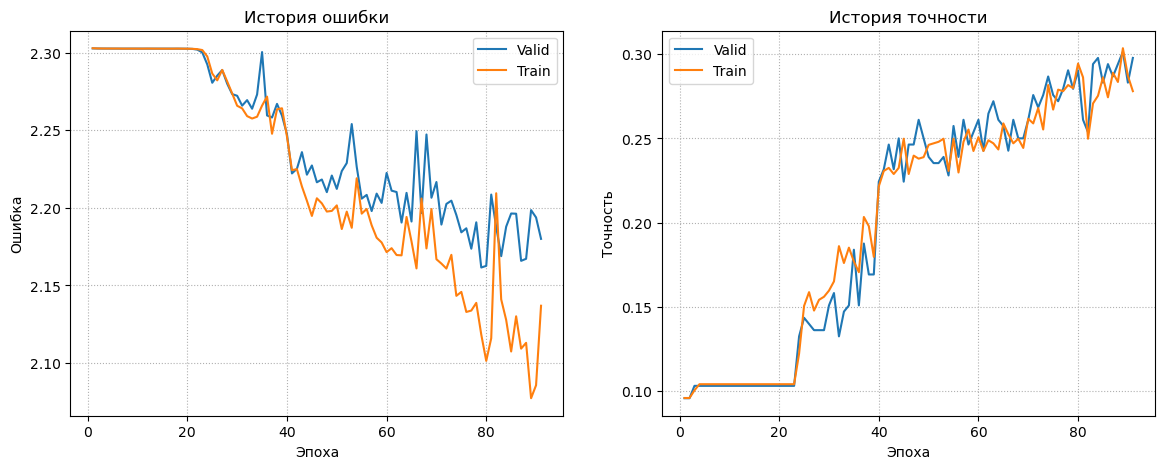

In [22]:
plot_tensoarboard_graphics(log_scalars)

# Summary